In [10]:
#importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

#known correlated stocks, apple and nvidia, 0.84 correlation coefficient (over my interval)
tickers = ['AAPL','NVDA']
startDate = '2021-12-31'
endDate =   '2023-06-08'
window = 252 # 1 year of trading days as our window
testStatistic = 0 # arbitrary test statistic


data = pd.DataFrame()
returns = pd.DataFrame()
for ticker in tickers:
    data[ticker] = yf.download(ticker, startDate, endDate)['Close']
    returns[ticker] = np.append(data[ticker][1:].reset_index(drop=True)/data[ticker][:-1].reset_index(drop=True) - 1 , 0)
#calculating returns for each stock by downloading data from yahoo finance, subtracting 1 to convert from capital gains to returns and appending 0 to make sure the lengths are equal.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Day: 2023-01-03 00:00:00|
Long NVDA and Short AAPL
Gross Return: 2.0%
Net Return: 1.9%
Cumulative Return: 1.9%
T-Statistic: -2.25
Day: 2023-01-04 00:00:00|
Long NVDA and Short AAPL
Gross Return: -2.22%
Net Return: -2.22%
Cumulative Return: -0.36%
T-Statistic: -2.39
Day: 2023-01-05 00:00:00|
Long NVDA and Short AAPL
Gross Return: 0.48%
Net Return: 0.48%
Cumulative Return: 0.12%
T-Statistic: -2.28
Day: 2023-01-06 00:00:00|
Long NVDA and Short AAPL
Gross Return: 4.77%
Net Return: 4.77%
Cumulative Return: 4.89%
T-Statistic: -1.99
Day: 2023-01-09 00:00:00|
Long NVDA and Short AAPL
Gross Return: 1.35%
Net Return: 1.35%
Cumulative Return: 6.31%
T-Statistic: -2.22
Day: 2023-01-10 00:00:00|
Long NVDA and Short AAPL
Gross Return: -1.53%
Net Return: -1.53%
Cumulative Return: 4.68%
T-Statistic: -2.04
Day: 2023-01-11 00:00:00|
Long NVDA and Short AAPL
Gross Return: 3.25%
Net Return: 3.25%
Cumulative Return: 8.08%
T-Statistic: -2.11
Day: 2023-01-12 00:00:00|
Long NVDA and Short AAPL
Gross Return: 1.

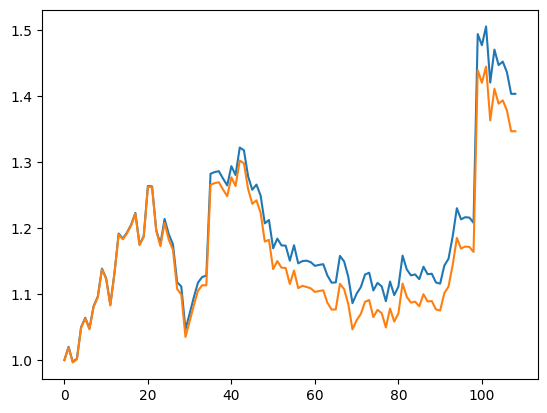

In [11]:
greturns = np.array([])
nreturns = np.array([])
t_stats = np.array([])

totalTrades = 0
for day in range(window, len(data)):
    #this method specifies the ideal dynamic equilbirum for our cointegration equaiton to trade upon between the two stocks. 
    def unit_root(b): 
        # using a linear regression line in the format "ticker2 = a + b * ticker1", given a parameter of b, we can find a by taking the average of ticker 2 and b * ticker 1
        a = np.average(data[tickers[1]][day-window:day] - b * data[tickers[0]][day-window:day])
        ticker2price = a + b * data[tickers[0]][day-window:day]
        diff = np.array(ticker2price - data[tickers[1]][day-window:day])
        derivdiff = diff[1:] - diff[:-1]
        #change in difference, helps us find the best signals, now we make our linear regression line, in my case a Ordinary Least Squares regression line (statsmodel)
        lm = sm.OLS(derivdiff , diff[:-1])
        results = lm.fit()
        return results.params[0]/results.bse[0]
        #We can get the t-statistic by dividing an OLS estimate, what we got in results by its standard error like above.  
   
    min = spop.minimize(unit_root, data[tickers[1]][day]/data[tickers[0]][day], method = 'Nelder-Mead')  
    #we use scipy minimize to find the minimum value of our unit root function, which is the best value of b for our cointegration equation. Chose nelder mead as it works best for simple functions (like ours).
    top = min.fun
    #gives us our optimal t value... we get this by plugging in the minb value into the unit root function.
    bop = float(min.x)
    #gives us optimal x value which would be the inputed parameter aka the b value. we use float to have python interpret it as a float opposed to an array.
    aop = np.average(data[tickers[1]][day-window:day] - bop * data[tickers[0]][day-window:day])
    # gives us optimal a value (found by using our new b optimal value)
    ticker2price = aop + bop * data[tickers[0]][day]
    #now we can take our newly found optimal values and fill in our cointegration equation to find the cointegrated value of ticker2.
    
    if day == window: ## if we're on the first day we set the old_sig 0
        old_sig = 0
    if top > testStatistic: # if the t-statistic is > our critical value, we don't trade as not significant enough 
        sig = 0
        greturn = 0
    else: # if our cointegration equation returns a positive number, we long ticker2 and short ticker1, if negative we short ticker2 and long ticker1
        totalTrades = totalTrades+1
        sig = np.sign(ticker2price - data[tickers[1]][day])
        greturn = sig*returns[tickers[1]][day] - sig*returns[tickers[0]][day] # gross return, calculated by subtracting the stock we are longing from the stock we are shorting
    
    nreturn = greturn - 0.001*abs(sig - old_sig) # subtracting 0.001% for trading costs 
    greturns = np.append(greturns, greturn) 
    nreturns = np.append(nreturns, nreturn)
    t_stats = np.append(t_stats, top)
    #appending values to overall arrays.
    print('Day: ' + str(data.index[day]) + '|')
    if sig == 0:
        print('No Trade')
    if sig == 1:
        print('Long ' + tickers[1] + ' and Short ' + tickers[0])
    if sig == -1:
        print('Short ' + tickers[1] + ' and Long ' + tickers[0])
    print('Gross Return: ' + str(round(greturn*100,2)) + '%')
    print('Net Return: ' + str(round(nreturn*100,2)) + '%')
    print('Cumulative Return: ' + str(round(np.prod(1+nreturns)*100-100,2)) + '%')
    print('T-Statistic: ' + str(round(top, 2)))
    #printing out values for each day 
    old_sig = sig
print('Total Trades: ' + str(totalTrades))
plt.plot(np.append(1,np.cumprod(1+greturns)))
plt.plot(np.append(1,np.cumprod(1+nreturns)))
#overall return graphs, adding 1 to give us capital gains


    
